<a href="https://colab.research.google.com/github/Seisr/Music_genre_classification/blob/master/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Audio to spectrogram

In [ ]:
file = '/content/drive/My Drive/Music/Clock Strikes - ONE OK ROCK.mp3'

In [ ]:
signal, sr = librosa.load(file, sr = 22050)

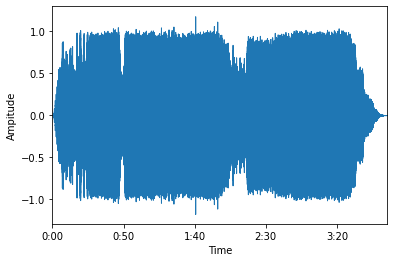

In [ ]:
librosa.display.waveplot(signal, sr=sr)
plt.xlabel('Time')
plt.ylabel('Ampitude')
plt.show()

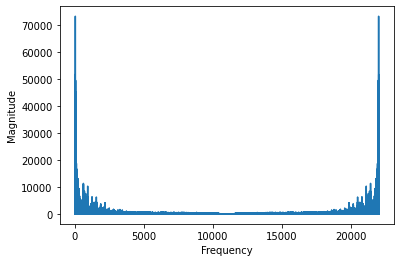

In [ ]:
# fft -> spectrum
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0,sr, len(magnitude))
plt.plot(frequency,magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

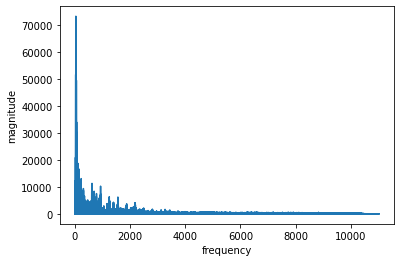

In [ ]:
# left spectrum
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]
plt.plot(left_frequency, left_magnitude)
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.show()

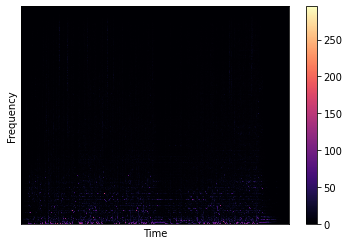

In [ ]:
# STFT -> Spectrogram
n_fft = 2048
hop_length = 512
stft = librosa.core.stft(signal, hop_length = hop_length, n_fft=n_fft)
spectrogram =np.abs(stft)


librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

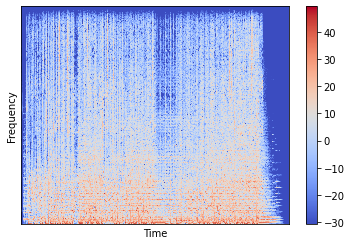

In [ ]:
# log spectrogram

log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

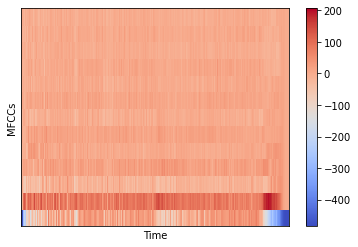

In [ ]:
# MFCCs
MFCCs = librosa.feature.mfcc(signal, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel('Time')
plt.ylabel('MFCCs')
plt.colorbar()
plt.show()

# Data Set

In [ ]:
import os
import math
import json
DATASET_PATH = "/content/drive/My Drive/Music"
JSON_PATH = "/content/drive/My Drive/Music/data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLE_PER_TRACK = SAMPLE_RATE * DURATION


def save_mfcc (DATASET_PATH, JSON_PATH, n_mfcc=13, n_fft=2048, hop_length=512, num_segments = 5):
    #dictionary to store data
    data = {
        "mapping": [],
        "mfccs": [],
        "label": []
    }

    num_samples_per_segment = int(SAMPLE_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length) # 1.2 -> 2

    # loop through all genre
    for i , (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):
      # ensure we not in root directory
      if dirpath is not DATASET_PATH:
        pass

        #save the semantic label

        dirpath_components = dirpath.split("/") #genres/blue => ['genres','blue']
        semantic_label = dirpath_components[-1]
        data['mapping'].append(semantic_label)
        print("\n Processing {}".format(semantic_label))

        #process file for a specific genre
        for f in filenames:
          file_path = os.path.join(dirpath, f)
          signal, sr= librosa.load(file_path, sr=SAMPLE_RATE) 

          # process segments extracting mfcc and storing data
          for s in range (num_segments):
            start_sample = num_samples_per_segment * s # s=0 -> 0
            finish_sample = start_sample + num_samples_per_segment # s=0 -> num_samples_per_segment

            
            mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                        sr=sr,
                                        n_fft=n_fft,
                                        n_mfcc=n_mfcc,
                                        hop_length=hop_length)
            mfcc = mfcc.T    
            # store mfcc for segment if it has expected length
            if len(mfcc) == expected_num_mfcc_vectors_per_segment:
              data['mfcc'].append(mfcc.tolist())
              data['labels'].append(i-1)
              print("{}, segment:{}".format(file_path,s+1))     

    with open(JSON_PATH, "w") as fp:
      json.dump(data, fp, indent = 4)

if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)